In [10]:
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
import torch
from ultralytics import YOLO
from PIL import Image
device = 'cuda'
model_path='weights/icon_detect_v1_5/model_v1_5.pt'

som_model = get_yolo_model(model_path)

som_model.to(device)
print('model to {}'.format(device))

model to cuda


In [11]:
# two choices for caption model: fine-tuned blip2 or florence2
import importlib
import utils
importlib.reload(utils)
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model
# caption_model_processor = get_caption_model_processor(model_name="blip2", model_name_or_path="weights/icon_caption_blip2", device=device)
caption_model_processor = get_caption_model_processor(model_name="florence2", model_name_or_path="weights/icon_caption_florence", device=device)



In [12]:
som_model.device, type(som_model) 

(device(type='cuda', index=0), ultralytics.models.yolo.model.YOLO)

In [13]:
# reload utils
import importlib
import utils
importlib.reload(utils)
from utils import get_som_labeled_img, check_ocr_box, get_caption_model_processor, get_yolo_model

image_path = 'imgs/google_page.png'


image = Image.open(image_path)
image_rgb = image.convert('RGB')
print('image size:', image.size)

box_overlay_ratio = max(image.size) / 3200
draw_bbox_config = {
    'text_scale': 0.8 * box_overlay_ratio,
    'text_thickness': max(int(2 * box_overlay_ratio), 1),
    'text_padding': max(int(3 * box_overlay_ratio), 1),
    'thickness': max(int(3 * box_overlay_ratio), 1),
}
BOX_TRESHOLD = 0.05

import time
start = time.time()
ocr_bbox_rslt, is_goal_filtered = check_ocr_box(image_path, display_img = False, output_bb_format='xyxy', goal_filtering=None, easyocr_args={'paragraph': False, 'text_threshold':0.8}, use_paddleocr=True)
text, ocr_bbox = ocr_bbox_rslt
cur_time_ocr = time.time() 

dino_labled_img, label_coordinates, parsed_content_list = get_som_labeled_img(image_path, som_model, BOX_TRESHOLD = BOX_TRESHOLD, output_coord_in_ratio=True, ocr_bbox=ocr_bbox,draw_bbox_config=draw_bbox_config, caption_model_processor=caption_model_processor, ocr_text=text,use_local_semantics=True, iou_threshold=0.7, scale_img=False, batch_size=128)
cur_time_caption = time.time() 


image size: (3239, 2159)

image 1/1 c:\Users\nkobe\workspace\OmniParser\imgs\google_page.png: 864x1280 51 icons, 10.2ms
Speed: 4.4ms preprocess, 10.2ms inference, 0.0ms postprocess per image at shape (1, 3, 864, 1280)


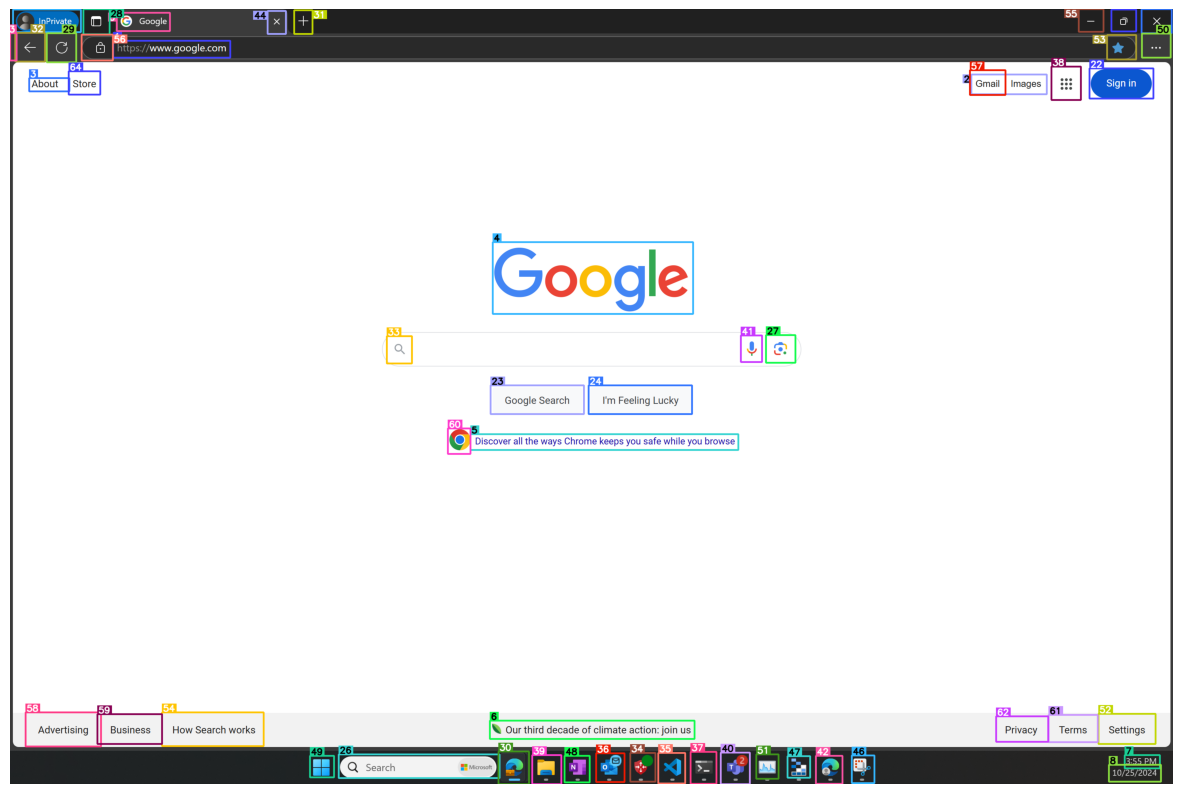

In [14]:
# plot dino_labled_img it is in base64
import base64
import matplotlib.pyplot as plt
import io
plt.figure(figsize=(15,15))

image = Image.open(io.BytesIO(base64.b64decode(dino_labled_img)))
plt.axis('off')

plt.imshow(image)
# print(len(parsed_content_list))


In [15]:
import pandas as pd
df = pd.DataFrame(parsed_content_list)
df['ID'] = range(len(df))

df

,type,bbox,interactivity,content,ID
0,text,"[0.09169496595859528, 0.0046317740343511105, 0...",False,G Google,0
1,text,"[0.08860759437084198, 0.0407596118748188, 0.18...",False,https://www.google.com,1
2,text,"[0.8264896869659424, 0.0842982828617096, 0.891...",False,GmailImages,2
3,text,"[0.016671812161803246, 0.08893006294965744, 0....",False,About,3
4,text,"[0.4149428904056549, 0.30060213804244995, 0.58...",False,Google,4
...,...,...,...,...,...
60,icon,"[0.3763536214828491, 0.5412358045578003, 0.396...",True,Google Chrome web browser.,60
61,icon,"[0.893078625202179, 0.9109764099121094, 0.9352...",True,Terms.,61
62,icon,"[0.8480026125907898, 0.9126327037811279, 0.892...",True,Privacy settings.,62
63,icon,"[0.0001498587371315807, 0.031176628544926643, ...",True,Search or magnifying glass.,63


In [16]:
parsed_content_list

[{'type': 'text',
  'bbox': [0.09169496595859528,
   0.0046317740343511105,
   0.13738808035850525,
   0.028253821656107903],
  'interactivity': False,
  'content': 'G Google'},
 {'type': 'text',
  'bbox': [0.08860759437084198,
   0.0407596118748188,
   0.18956467509269714,
   0.06252894550561905],
  'interactivity': False,
  'content': 'https://www.google.com'},
 {'type': 'text',
  'bbox': [0.8264896869659424,
   0.0842982828617096,
   0.8913244605064392,
   0.10977303981781006],
  'interactivity': False,
  'content': 'GmailImages'},
 {'type': 'text',
  'bbox': [0.016671812161803246,
   0.08893006294965744,
   0.050941649824380875,
   0.10606762021780014],
  'interactivity': False,
  'content': 'About'},
 {'type': 'text',
  'bbox': [0.4149428904056549,
   0.30060213804244995,
   0.5872182846069336,
   0.3932376205921173],
  'interactivity': False,
  'content': 'Google'},
 {'type': 'text',
  'bbox': [0.3958011865615845,
   0.5484020113945007,
   0.6261191964149475,
   0.568781852722168